In [15]:
import sys
sys.path.append('C:\\Users\\Максимилиан\\Desktop\\Skoltech\\Reinforcement learning\\Final project')
import Dynamics
from casadi import *
from IPython.display import HTML
import Environment
import gym

### hyperparameters

In [16]:
T = 0.4 # MPC horizon
N = 8 # horion divides on N steps

# boundary conditions
U_MAX = 20 
U_MIN = - U_MAX



### Creation of integrator
$
\dot{
\begin{pmatrix}
     {\phi} \\
     {\phi}
\end{pmatrix}} = 
\begin{pmatrix}
     {\dot{\phi}} \\
     {rhs}
\end{pmatrix}
$

In [17]:
x = vertcat(Dynamics.phi,Dynamics.dphi)
u = Dynamics.u

ode = Dynamics.my_rhs(x[:3],x[3:],u)
dae = {'x':x, 'p':u, 'ode':ode}
intg_options = {'tf': T/N}

intg = integrator('intg','rk',dae,intg_options)

### Problem dimention

In [18]:
x_dim = 6
u_dim = 1

### MPC formulation

#### initialization

In [19]:
opti = casadi.Opti()
x = opti.variable(x_dim*(N+1)) # all state history shape x_dim*(N+1)
u = opti.variable(u_dim *N) # u history
x0 = opti.parameter(x_dim) # initial x0 state
xgoal = opti.parameter(x_dim*(N+1)) # goal state

# opti.parameter is const, we will set up it latter
# opti.variable will be variated by casadi methods

#### constraints and conditions

In [20]:
weights = [0,1,1,0,0,0] # ТУУУУУТ ВЕСА ВЕСА ТУУУУУУУТ

dx = x - xgoal # error
weighted_sum = dx.T @ np.diag(weights * (N+1)) @dx 

opti.minimize(weighted_sum) # try minimize error

opti.subject_to(x[0:x_dim] == x0)
for k in range(1,N+1):
    opti.subject_to(x[k*x_dim : (k+1)*x_dim] == \
                    intg(x0 = x[(k-1)*x_dim : k*x_dim],p = u[(k-1)*u_dim : k*u_dim])['xf'])

for i in range(N):
        opti.subject_to(opti.bounded(U_MIN,u[i*u_dim],U_MAX))

#### constract solver from "opti" settings

In [21]:
opti_options = {'print_in':False, 'print_out':False, 'print_time':False}
solver_options = {'print_level' : 0}

opti.solver('ipopt',opti_options,solver_options)
mpc = opti.to_function("MPC",[x0,xgoal],[u],["x0","xgoal"],["u_opt"])
mpc

Function(MPC:(x0[6],xgoal[54])->(u_opt[8]) MXFunction)

###  Environment testing

In [22]:
env = Environment.DoublePendulumEnv([0,3.14/2 +  3 *2 * np.pi / 360,3.14/2 + 3 * 2 * np.pi / 360,0,0,0],dt = T/N ) # initialise system
x_calc_goal = np.array([0,np.pi/2,np.pi/2,0,0,0]*(N+1),dtype = float) # state_goal

Environment initialized


#### loop
* x = env.state
* u = mpc(x,goal)  - give optimal u variable with shape u_dim * N
* env.step(u[0]) - apply first action


In [23]:
env.reset()
x0_calc = env.state
NumSteps = 150

X_story = [0]*NumSteps
X_story[0] = x0_calc
X_real = [0]*NumSteps
X_real[0] = x0_calc
U_hist = []

for i in range(1,NumSteps):
    u = mpc(env.state,x_calc_goal).full()
    u = u[0]
    U_hist.append(u)
    env.step(u)
    
    x0_calc = intg(x0 = x0_calc,p = u)['xf'].full() # it is integrator from mpc for testing consistency of predictions between env and mpc
    X_real[i] = env.state
    X_story[i] = np.array(x0_calc)

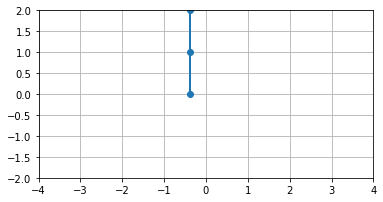

In [24]:
ani = env.render()
HTML(ani.to_jshtml())

In [26]:
env.action_history

[array([15.60628876]),
 array([-19.99818525]),
 array([8.0759735]),
 array([-8.27784977]),
 array([8.16507905]),
 array([-9.12692226]),
 array([9.04989201]),
 array([-9.86277363]),
 array([9.79211898]),
 array([-10.45010195]),
 array([10.37436437]),
 array([-10.88690485]),
 array([10.80475112]),
 array([-11.19069954]),
 array([11.10609121]),
 array([-11.38785214]),
 array([11.30626783]),
 array([-11.50582294]),
 array([11.43198785]),
 array([-11.56873314]),
 array([11.50567435]),
 array([-11.595615]),
 array([11.5445768]),
 array([-11.6003414]),
 array([11.56112727]),
 array([-11.59237941]),
 array([11.56382521]),
 array([-11.57780483]),
 array([11.55822197]),
 array([-11.56027393]),
 array([11.54779536]),
 array([-11.54182351]),
 array([11.53463995]),
 array([-11.52347093]),
 array([11.51997082]),
 array([-11.50563335]),
 array([11.50446911]),
 array([-11.48840322]),
 array([11.48850682]),
 array([-11.47171848]),
 array([11.47228542]),
 array([-11.4554605]),
 array([11.45591705]),
 ar

In [12]:
x_calc_goal

array([0.        , 1.57079633, 1.57079633, 0.        , 0.        ,
       0.        , 0.        , 1.57079633, 1.57079633, 0.        ,
       0.        , 0.        , 0.        , 1.57079633, 1.57079633,
       0.        , 0.        , 0.        , 0.        , 1.57079633,
       1.57079633, 0.        , 0.        , 0.        , 0.        ,
       1.57079633, 1.57079633, 0.        , 0.        , 0.        ,
       0.        , 1.57079633, 1.57079633, 0.        , 0.        ,
       0.        , 0.        , 1.57079633, 1.57079633, 0.        ,
       0.        , 0.        , 0.        , 1.57079633, 1.57079633,
       0.        , 0.        , 0.        , 0.        , 1.57079633,
       1.57079633, 0.        , 0.        , 0.        ])

In [13]:
U_hist

[array([1.20882202]),
 array([-2.9091957]),
 array([2.7270075]),
 array([-2.9360461]),
 array([2.78243035]),
 array([-2.95142086]),
 array([2.82534244]),
 array([-2.95964968]),
 array([2.85818536]),
 array([-2.96241845]),
 array([2.88224074]),
 array([-2.96138039]),
 array([2.89946112]),
 array([-2.95808577]),
 array([2.91151433]),
 array([-2.95367678]),
 array([2.91973929]),
 array([-2.94892791]),
 array([2.92516543]),
 array([-2.94431701]),
 array([2.92856069]),
 array([-2.94010189]),
 array([2.9304865]),
 array([-2.93638915]),
 array([2.9313488]),
 array([-2.93318955]),
 array([2.93144008]),
 array([-2.93045915]),
 array([2.93097186]),
 array([-2.92812786]),
 array([2.93009845]),
 array([-2.92611782]),
 array([2.92893372]),
 array([-2.92435424]),
 array([2.92756261]),
 array([-2.92277111]),
 array([2.92604906]),
 array([-2.92131338]),
 array([2.9244413]),
 array([-2.91993723]),
 array([2.9227756]),
 array([-2.9186091]),
 array([2.92107891]),
 array([-2.91730422]),
 array([2.91937087

In [14]:
dx @ np.array([[10,10],[10,10]])

RuntimeError: .../casadi/core/sparsity.cpp:414: Assertion "x.size2()==y.size1()" failed:
Matrix product with incompatible dimensions. Lhs is 54x1 and rhs is 2x2.